In [1]:
## Standard Stuff
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import dask.array as da
import numcodecs

## HEALPix Specific
import healpix as hp
import easygems.healpix as egh
import easygems.remap as egr

import intake     # For catalogs
import zarr

# Ilan
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
#from icecream import ic
#import nc_time_axis
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

In [2]:
catfn='/home/tmerlis/hackathon/xsh24_scream_main.yaml'
combo_cat = intake.open_catalog(catfn)

# 'coarse' is an online coarse-graining of 8 neighboring grid cells ~25km
# xsh24 = X-SHiELD 2024 model version, unpublished
# xsh21 = X-SHiELD 2021 model version, many articles including Cheng et al. 2022 GRL
print(list(combo_cat)) 

['xsh24_coarse', 'xsh24_native', 'xsh21_coarse', 'scream2D_hrly', 'scream_ne120', 'scream_lnd']


In [3]:
# select zoom level and the part of the combined catalog you're interested in
# coarse stores are available at zoom 7 ~50km and lower
zoom_select = 7
ds = combo_cat.xsh24_coarse(zoom=zoom_select).to_dask()
# attach coordinates; otherwise can't use lat and lon and selecting regions or taking a zonal mean won't work
ds = ds.pipe(egh.attach_coords)

# native stores are available at zoom 10 ~6.4km and lower, fewer variables and all are 2d
# ds = combo_cat.xsh24_native(zoom=zoom_select).to_dask()
# ds = ds.pipe(egh.attach_coords)

# # we downloaded output from DOE's SCREAM model to stellar
# # conceivably, we could add to our local collection of models during the week
# # or augment the catalog with observational datasets
# ds_scream = combo_cat.scream_ne120(zoom=zoom_select).to_dask()
# ds_scream = ds_scream.pipe(egh.attach_coords)

/home/ee5357/.conda/envs/easy25/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


#### Variables (coarse model)
CPRATEsfc_coarse: coarsened 2D 3 hr surface convective precipitation rate 
HPBLsfc_coarse: coarsened 2D 3 hr surface planetary boundary layer height [m] 
LHTFLsfc_coarse: coarsened 2D 3 hr surface latent heat flux [W/m**2]
pr_coarse: coarsened 2D 3 hr bucket surface precipitation rate
meantbclrisccp_coarse: coarsened 2D 3 hr ISCCP clear-sky 10.5 micron brightness temperature / toa_brightness_temperature_assuming_clear_sky 
meantbisccp_coarse: coarsened 2D 3 hr ISCCP all-sky 10.5 micron brightness temperature / toa_brightness_temperature 

#### Variables (native model)
pr: native-res 2D 3 hr bucket surface precipitation rate
40dBz_height: native-res 2D 3 hr Height of 40 dBz reflectivity 
CAPE_max: native-res 2D 3 hr Convective available potential energy (surface-based)
soilm: native-res 2D 24 hr total column soil moisture content [kg/m**2]
uh25_max: native-res 2D 3 hr 2-5 km Updraft Helicity 
uh25_min: native-res 2D 3 hr 2-5 km Updraft Helicity
wmaxup_max: native-res 2D 3 hr column-maximum updraft (below 100 mb)
meantbisccp: native-res 2D 3 hr ISCCP all-sky 10.5 micron brightness temperature / toa_brightness_temperature

In [64]:
def worldmap(var, **kwargs):
    #projection = ccrs.Robinson(central_longitude=-135.5808361)
    projection = ccrs.Robinson(central_longitude=0)
    fig, ax = plt.subplots(
        figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
    )
    ax.set_global()

    hpshow = egh.healpix_show(var, ax=ax, **kwargs)
    cbar = plt.colorbar(hpshow, ax=ax, orientation='vertical', 
                    pad=0.05, shrink=0.8)
    ax.add_feature(cf.COASTLINE, linewidth=0.8)
    ax.add_feature(cf.BORDERS, linewidth=0.4)
    
def usmap(var, title, cbar_title, **kwargs):
    #projection = ccrs.Robinson(central_longitude=-135.5808361)
    projection = ccrs.Robinson(central_longitude=-90)
    fig, ax = plt.subplots(
        figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
    )
    ax.set_extent([-130, -70, 20, 50])

    """
    egh.healpix_show(
    data.prw.isel(time=0), ax=ax, cmap="Blues", vmin=45, vmax=75, method="linear"
    )
    contour_lines = egh.healpix_contour(
        data.prw.isel(time=0), ax=ax, levels=[45, 50], colors="grey", linewidths=1, alpha=1
    )
    plt.clabel(contour_lines, inline=True, fontsize=8, colors="grey", fmt="%d")
    """
    
    hpshow = egh.healpix_show(var, ax=ax, **kwargs)
    # not sure if this works
    # egh.healpix_show(var, ax=ax, cmap="Blues", method="linear", **kwargs)
    # contours = egh.healpix_contour(var, ax=ax, colors='gray', linewidths=2)
    # plt.clabel(contours, inline=True, fontsize=8, colors="grey", fmt="%d")
    cbar = plt.colorbar(hpshow, ax=ax, orientation='vertical', pad=0.05, shrink=0.8, label=cbar_title)

    ax.add_feature(cf.COASTLINE, linewidth=0.8)
    #ax.coastlines(linewidth=0.8)
    ax.add_feature(cf.BORDERS, linewidth=0.4)
    ax.add_feature(cf.STATES, linewidth=0.4)
    ax.set_title(title)

In [57]:
# def preprocess(ds):
#     res = ds \
#         .assign(wind=lambda x: np.sqrt(x['ua']**2 + x['va']**2)) \
#         .assign(height=lambda x: x['zg']) # geopotential
#     #.assign(swind=lambda x: np.sqrt(x['uas']**2 + x['vas']**2)) \
#     return res

# Select the GPPLJ regions
us = ((ds.lat <= 50) & (ds.lat >= 20) & (ds.lon >= -130+360) & (ds.lon <= -70+360))
ds_us = ds.isel(cell=us)
#print(ds_us.uas.coords)
#print(ds_us.uas.sel(time='2020-06-06 00:00:00'))
#usmap(ds_us.uas.sel(time=slice('2020-06-01', '2020-07-01')).mean('time'))

In [58]:
llj_comp = xr.open_dataset('/scratch/cimes/iv4111/hk25-data/llj_XSHIELD_uv.h5', chunks={})
llj_count = xr.open_dataset('/scratch/cimes/iv4111/hk25-data/llj_XSHIELD.h5', chunks={})
# usmap(((llj_comp.jet_u ** 2 + llj_comp.jet_v ** 2) ** 0.5).mean('time'), 'a', 'b')
# usmap(llj_count.speed.mean('time'), 'a', 'b')
# 0ct 20 2019 - Jan 7 2021
#print(llj_count.mask.sel(time='2020-06-06 00:00:00').squeeze())
#print(llj_count.mask.isel(time=0))

#### MCS ID metrics
* Heavy rain rate thresh: 5 mm/hr
* Min rain rate thresh: 0.5 mm/hr
* cloudtb_core:  225.0  # [K]
* cloudtb_cold:  241.0  # [K]
* cloudtb_warm:  261.0  # [K]
* cloudtb_cloud:  261.0  # [K]
* absolutetb_threshs: [160, 330]

In [59]:
t = '2020-06-30 00:00:00'

# select for just 2020
t_window = slice('2020-01-01 00:00:00', '2020-12-31 21:00:00')
llj_uv = llj_comp.sel(time=t_window)
lljs = llj_count.sel(time=t_window)
ds_us = ds_us.sel(time=t_window)
#usmap(llj_count.mask.sel(time=t).squeeze())

#print(ds_us)
pconv = 3600  # 1 mm == 1 kg/m2, 3600 s / hr
us_precip = ds_us.pr * pconv  # kg / m2 / s --> mm/hr
#print(us_precip)
us_tb = (ds_us.rlut / 5.6693e-8) ** 0.25

# spatial filtering, add gaussian check cam MJO code
us_precip.rolling(dim={'time': 3}, min_periods=3)
lljs.mask.rolling(dim={'time': 3}, min_periods=3)
us_tb.rolling(dim={'time': 3}, min_periods=3)
#usmap(us_precip.sel(time=t).squeeze())

jet_mask = lljs.mask.sel(time=t).squeeze()
# TODO: some dependence on LLJ max speed? like
pre = us_precip.sel(time=t).squeeze()
tb = us_tb.sel(time=t).squeeze()

#usmap(jet_mask)
# usmap(pre)
# usmap(tb)
# # ds_us

prep = pre.where(pre > 5.0)
#usmap(prep)

filter_tb = tb.where(tb < 241.0)
#usmap(filter_tb)

Climatology
* directionality
* seasonality
* diurnal cycle
* elevation
* background flow?

[########################################] | 100% Completed | 534.37 ms


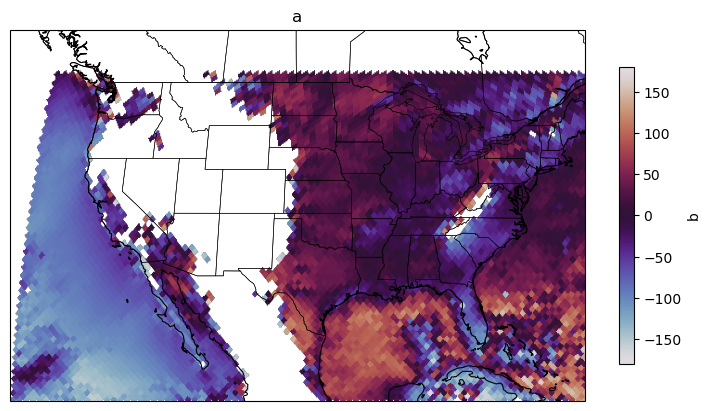

In [65]:
# directionality
direction = np.degrees(np.arctan2(llj_uv.jet_v, llj_uv.jet_u))  # deg ccw from true E, possible to group these somehow how quiver plot

# def get_nn_lon_lat_index(nside, lons, lats):
#     lons2, lats2 = np.meshgrid(lons, lats)
#     return xr.DataArray(
#         hp.ang2pix(nside, lons2, lats2, nest=True, lonlat=True),
#         coords=[("lat", lats), ("lon", lons)],
#     )

# idx = get_nn_lon_lat_index(
#     # ax.set_extent([-130, -70, 20, 50])
#     2 ** zoom_select, np.linspace(-130, -70, 200), np.linspace(20, 50, 120)
# )
# lon_lat = direction.isel(time=0, cell=idx)
# lon_lat.plot()
usmap(direction.mean('time'), 'a', 'b', vmin=-180, vmax=180, cmap='twilight')

[########################################] | 100% Completed | 114.45 ms
[########################################] | 100% Completed | 112.34 ms


/home/ee5357/.conda/envs/easy25/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


[########################################] | 100% Completed | 116.64 ms


/home/ee5357/.conda/envs/easy25/lib/python3.12/site-packages/xarray/core/common.py:181: RuntimeWarning: invalid value encountered in cast
  return np.array(self.values, dtype=dtype, copy=copy)
/home/ee5357/.conda/envs/easy25/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


[########################################] | 100% Completed | 104.18 ms


/home/ee5357/.conda/envs/easy25/lib/python3.12/site-packages/xarray/core/common.py:181: RuntimeWarning: invalid value encountered in cast
  return np.array(self.values, dtype=dtype, copy=copy)


<Figure size 800x400 with 0 Axes>

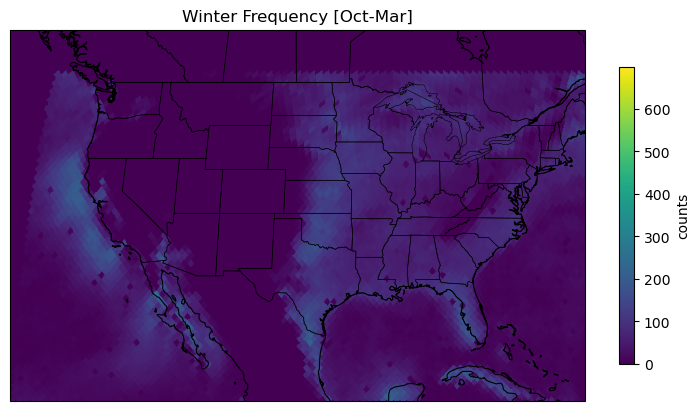

In [77]:
# seasonality
# data available for 0ct 20 2019 - Jan 7 2021
# just use 2020 then
Oct2Dec = slice('2020-10-01 00:00:00', '2020-12-31 21:00:00')  # 'winter'
Jan2Mar = slice('2020-01-01 00:00:00', '2020-03-31 21:00:00')  # 'winter'
Apr2Sep = slice('2020-04-01 00:00:00', '2020-09-30 21:00:00')  # 'summer'

summer = lljs.sel(time=Apr2Sep)
winter = xr.concat([lljs.sel(time=Jan2Mar), lljs.sel(time=Oct2Dec)], dim='time')
sum_counts = summer.mask.astype(int).sum('time')
win_counts = winter.mask.astype(int).sum('time')
cmax = max(sum_counts.max().values[()], win_counts.max().values[()])
usmap(sum_counts, 'Summer Frequency [Apr-Sept]', 'counts', vmin=0, vmax=cmax)
plt.savefig('./sum.png', dpi=300)
plt.clf()
usmap(win_counts, 'Winter Frequency [Oct-Mar]', 'counts', vmin=0, vmax=cmax)
plt.savefig('./win.png', dpi=300)

[########################################] | 100% Completed | 427.84 ms
905
[########################################] | 100% Completed | 316.37 ms
[########################################] | 100% Completed | 316.27 ms


/home/ee5357/.conda/envs/easy25/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


[########################################] | 100% Completed | 318.11 ms


/home/ee5357/.conda/envs/easy25/lib/python3.12/site-packages/xarray/core/common.py:181: RuntimeWarning: invalid value encountered in cast
  return np.array(self.values, dtype=dtype, copy=copy)
/home/ee5357/.conda/envs/easy25/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


[########################################] | 100% Completed | 322.46 ms


/home/ee5357/.conda/envs/easy25/lib/python3.12/site-packages/xarray/core/common.py:181: RuntimeWarning: invalid value encountered in cast
  return np.array(self.values, dtype=dtype, copy=copy)


<Figure size 800x400 with 0 Axes>

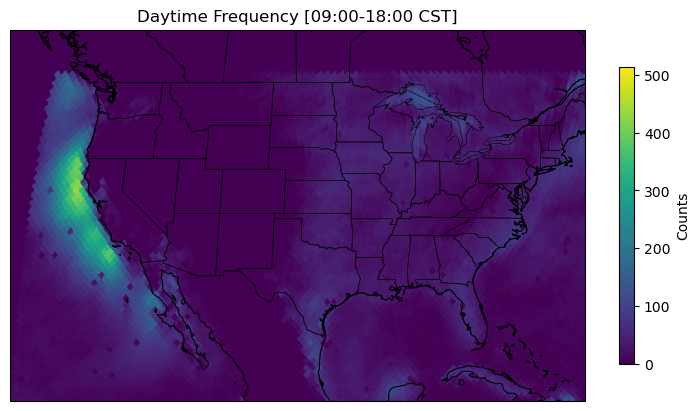

In [76]:
# diurnal cycle - use seasonal breakdown as well?
# do this by index..? probably easier 2020-01-01 00:00:00 -- 2020-12-31 21:00:00
# UTC!! LOCAL TIME -> -6 hours
# noct_strt = '21:00:00'  # day before --> 03:00:00
# noct_end = '06:00:00'  12:00:00
# day_strt = '09:00:00'  15:00:00
# day_end = '18:00:00'  00:00:00

# there is one extra chunk for daytime
nocturnal = xr.concat([lljs.isel(time=slice(i, i + 4)) for i in range(1, len(lljs.mask.time), 8)][:-1], dim='time')
daytime = xr.concat([lljs.isel(time=slice(i, i + 4)) for i in range(5, len(lljs.mask.time), 8)], dim='time')
noc_counts = nocturnal.mask.astype(int).sum('time')
day_counts = daytime.mask.astype(int).sum('time')
total = noc_counts + day_counts
print(total.max().values[()])
# noc_counts = noc_counts / total * 100
# day_counts = day_counts / total * 100
cmax = max(noc_counts.max().values[()], day_counts.max().values[()])
usmap(noc_counts, 'Nocturnal Frequency [21:00-06:00 CST]', 'Counts', vmin=0, vmax=cmax)
plt.savefig('./noc.png', dpi=300)
plt.clf()
usmap(day_counts, 'Daytime Frequency [09:00-18:00 CST]', 'Counts', vmin=0, vmax=cmax)
plt.savefig('./day.png', dpi=300)